<a href="https://colab.research.google.com/github/kg497/CS301/blob/dev/CS301_Project_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#based on https://www.kaggle.com/code/himanshubag/patent-matching-glove-embd
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from google.colab import files

import numpy as np 
import pandas as pd 

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/train.csv')
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB
None


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [4]:
test_df = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/test.csv')
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB
None


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [5]:
sample_sub = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/sample_submission.csv')
sample_sub.head()

,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [6]:
train_df['anchor'].value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [7]:
train_df['target'].value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

In [8]:
train_df['context'].value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

In [9]:
cpc = pd.read_csv(r'drive/My Drive/Colab Notebooks/Project/titles.csv')
cpc.head()

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


In [10]:
cpc = cpc.rename(columns = {"code" : "context"})
train_df = pd.merge(train_df, cpc[["context","title"]], on ="context", how = "left")
test_df = pd.merge(test_df, cpc[["context","title"]], on ="context", how = "left")

In [11]:
train_df.head()

,id,anchor,target,context,score,title
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


In [12]:
def clean(x):
    t = x.lower()
    t = t.replace("[",'')
    t = t.replace(";",'')
    t = t.replace(",",'')
    t = t.replace("]",'')
    t = t.replace(":",'')
    t= t.replace("or", '')
    t= t.replace("and", '')
    t= t.replace("the", '')
    t= t.replace("for", '')
    t= t.replace("of", '')
    t=t.replace("in",'')
    t= t.replace("a",'')
    t =t.replace("of",'')
    return t

train_df['title'] = train_df['title'].apply(lambda x: clean(x))
test_df['title'] = test_df['title'].apply(lambda x: clean(x))

In [13]:
train_df.head()

print(train_df.loc[0,'title'])

furniture domestic rticles  pplinces cfee mills spice mills suction cleners  generl


In [14]:
train_df['sen1'] = train_df['anchor'].astype('str')+' '+train_df['title'].astype('str')
test_df['sen1'] = test_df['anchor'].astype('str')+' '+test_df['title'].astype('str')

In [15]:
train_df.drop(['anchor','context','title'],axis=1,inplace=True)
test_df.drop(['anchor','context','title'],axis=1,inplace=True)
train_df.head()

,id,target,score,sen1
0,37d61fd2272659b1,abatement of pollution,0.50,abatement furniture domestic rticles pplinces...
1,7b9652b17b68b7a4,act of abating,0.75,abatement furniture domestic rticles pplinces...
2,36d72442aefd8232,active catalyst,0.25,abatement furniture domestic rticles pplinces...
3,5296b0c19e1ce60e,eliminating process,0.50,abatement furniture domestic rticles pplinces...
4,54c1e3b9184cb5b6,forest region,0.00,abatement furniture domestic rticles pplinces...


In [16]:
test_df.head()

,id,target,sen1
0,4112d61851461f60,inorganic photoconductor drum,opc drum optics
1,09e418c93a776564,altering gas flow,adjust gas flow combustion pprtus combustion p...
2,36baf228038e314b,lower locating,lower trunnion vehicles generl
3,1f37ead645e7f0c8,upper portion,cap component tretment textiles like lunder...
4,71a5b6ad068d531f,artificial neural network,neural stimulation electric communiction techn...


Glove Embeddings


In [17]:
path_to_glove_file = 'drive/My Drive/Colab Notebooks/Project/glove.6B.200d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [18]:
embeddings_index['<oov>'] = jnp.zeros((200,),dtype='float32')

In [19]:
embeddings_index.get('<oov>')

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0.], dtype=float32)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

res = []
for idx,row in train_df.iterrows():
    sen1 = row['sen1'].split(' ')
    sen2 = row['target'].split(' ')
    
    vec1 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen1]),axis=0)
    vec2 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen2]),axis=0)

    cosine = cosine_similarity([vec1], [vec2])
    res.append(round(float(cosine[0]),3))

In [21]:
print(len(res))
print(train_df.shape)

36473
(36473, 4)


In [22]:
train_df['word_embed_score'] = res

In [23]:
train_df.head()

,id,target,score,sen1,word_embed_score
0,37d61fd2272659b1,abatement of pollution,0.50,abatement furniture domestic rticles pplinces...,0.476
1,7b9652b17b68b7a4,act of abating,0.75,abatement furniture domestic rticles pplinces...,0.327
2,36d72442aefd8232,active catalyst,0.25,abatement furniture domestic rticles pplinces...,0.264
3,5296b0c19e1ce60e,eliminating process,0.50,abatement furniture domestic rticles pplinces...,0.386
4,54c1e3b9184cb5b6,forest region,0.00,abatement furniture domestic rticles pplinces...,0.282


In [24]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(train_df['score'].values,train_df['word_embed_score'].values)
error

0.09568989822608504

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

res = []
for idx,row in test_df.iterrows():
    sen1 = row['sen1'].split(' ')
    sen2 = row['target'].split(' ')
    
    vec1 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen1]),axis=0)
    vec2 = jnp.mean(jnp.array([embeddings_index.get(word,embeddings_index['<oov>']) for word in sen2]),axis=0) 
    cosine = cosine_similarity([vec1], [vec2])
    
    res.append([row['id'],round(float(cosine[0]),3)])

In [26]:
len(res),test_df.shape

(36, (36, 3))

In [27]:
res = [[i[0],i[1]] if i[1]>=0 else [i[0],0.0] for i in res]
res


[['4112d61851461f60', 0.512],
 ['09e418c93a776564', 0.807],
 ['36baf228038e314b', 0.632],
 ['1f37ead645e7f0c8', 0.467],
 ['71a5b6ad068d531f', 0.686],
 ['474c874d0c07bd21', 0.681],
 ['442c114ed5c4e3c9', 0.557],
 ['b8ae62ea5e1d8bdb', 0.516],
 ['faaddaf8fcba8a3f', 0.5],
 ['ae0262c02566d2ce', 0.895],
 ['a8808e31641e856d', 0.42],
 ['16ae4b99d3601e60', 0.537],
 ['25c555ca3d5a2092', 0.778],
 ['5203a36c501f1b7c', 0.813],
 ['b9fdc772bb8fd61c', 0.692],
 ['7aa5908a77a7ec24', 0.266],
 ['d19ef3979396d47e', 0.205],
 ['fd83613b7843f5e1', 0.583],
 ['2a619016908bfa45', 0.0],
 ['733979d75f59770d', 0.752],
 ['6546846df17f9800', 0.37],
 ['3ff0e7a35015be69', 0.209],
 ['12ca31f018a2e2b9', 0.739],
 ['03ba802ed4029e4d', 0.352],
 ['c404f8b378cbb008', 0.538],
 ['78243984c02a72e4', 0.538],
 ['de51114bc0faec3e', 0.755],
 ['7e3aff857f056bf9', 0.636],
 ['26c3c6dc6174b589', 0.612],
 ['b892011ab2e2cabc', 0.856],
 ['8247ff562ca185cc', 0.212],
 ['c057aecbba832387', 0.482],
 ['9f2279ce667b21dc', 0.899],
 ['b9ea2b06a878d

In [28]:
s = pd.DataFrame(res,columns=['id','score'])
s.head()

,id,score
0,4112d61851461f60,0.512
1,09e418c93a776564,0.807
2,36baf228038e314b,0.632
3,1f37ead645e7f0c8,0.467
4,71a5b6ad068d531f,0.686


In [29]:
s.to_csv('submission.csv',index=False)


Comparing the Scores


In [30]:
embedScoreArr = jnp.asarray(train_df['word_embed_score'])
scoreArr = jnp.asarray(train_df['score'])

In [31]:
print(scoreArr)

[0.5  0.75 0.25 ... 0.5  0.75 0.5 ]


In [32]:
print(embedScoreArr)

[0.476 0.327 0.264 ... 0.364 0.513 0.327]


<Figure size 432x288 with 0 Axes>

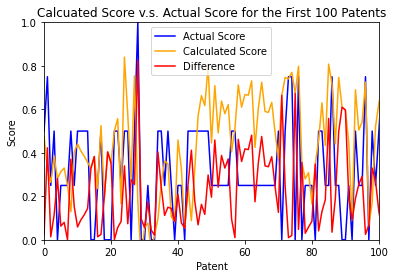

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

num = list(range(0,len(scoreArr)))

f = plt.figure()
#f.set_figwidth(500)
#f.set_figheight(100)

fix, ax = plt.subplots()
plt.plot(num, scoreArr, color='b', label='Actual Score')
plt.plot(num, embedScoreArr, color='orange', label='Calculated Score')
plt.plot(num, abs(scoreArr - embedScoreArr), color = 'r', label = 'Difference')

plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 100])
plt.ylabel('Score')
plt.xlabel('Patent')
plt.title('Calcuated Score v.s. Actual Score for the First 100 Patents')
plt.show()

Correlation:

In [34]:
corr = jnp.corrcoef(embedScoreArr, scoreArr)
print("correlation between the calculated score and the given score = " + str(corr[0][1]))

correlation between the calculated score and the given score = 0.3349411
